This notebook is different from v1 in two major steps:
1. In v1 `ct_flw_http_mthd` (53%), `is_ftp_login` (56%), and `ct_ftp_cmd` (56%) had large amounts of missing values  which were imputed with zeros. In this version we are dropping those two columns entirely.<br>
2. Cross-referencing results of VIF, Pearson Correlation, and feature importance with random forest to remove some of the columns. Reduced the number of features from 207 to 23.
3. Increased the test split from 10% to 15%.
4. Identified columns with a wide range of possible values to perform log-transformation<br>
~5. Log transformation of xxx numerical columns that have a wide range of possible values.~

## Downloading the Data

In [ ]:
# # Mount google drive 
# from google.colab import drive
# drive.mount('/content/drive')
# # change the directory to be able to import secret.py
# %cd /content/drive/MyDrive/

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split

Link to the dataset description: https://research.unsw.edu.au/projects/unsw-nb15-dataset

Link to the folder with files: https://cloudstor.aarnet.edu.au/plus/index.php/s/2DhnLGDdEECo4ys?path=%2FUNSW-NB15%20-%20CSV%20Files

In [ ]:
# all files have been downloaded to the personal Google Drive
# pulling them down one by one
!gdown '1edR5QGuXZJrvu71izVCsZKh2qBouWYJ6' -O train.csv
!gdown '1dHgzMHeY1t3ZYbLhRx8ViHsDIwbMvxNH' -O test.csv
!gdown '1LDZsf75FCSsHCVr8rpLBt2TpFKVzN3z9' -O one.csv
!gdown '1EYSkG8iqaVKNCiM5tDXjn6wzhkrVRv_4' -O two.csv
!gdown '10ybqEC3ps2LvGh74hRzgMeSE4oSlfoGN' -O three.csv
!gdown '1OcVMc1DtwKdS_-3oWFJz3kABCR9cJmly' -O four.csv

Downloading...
From: https://drive.google.com/uc?id=1edR5QGuXZJrvu71izVCsZKh2qBouWYJ6
To: /content/train.csv
100% 15.4M/15.4M [00:00<00:00, 53.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dHgzMHeY1t3ZYbLhRx8ViHsDIwbMvxNH
To: /content/test.csv
100% 32.3M/32.3M [00:00<00:00, 51.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LDZsf75FCSsHCVr8rpLBt2TpFKVzN3z9
To: /content/one.csv
100% 169M/169M [00:03<00:00, 44.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EYSkG8iqaVKNCiM5tDXjn6wzhkrVRv_4
To: /content/two.csv
100% 165M/165M [00:00<00:00, 167MB/s]
Downloading...
From: https://drive.google.com/uc?id=10ybqEC3ps2LvGh74hRzgMeSE4oSlfoGN
To: /content/three.csv
100% 155M/155M [00:03<00:00, 43.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OcVMc1DtwKdS_-3oWFJz3kABCR9cJmly
To: /content/four.csv
100% 97.6M/97.6M [00:00<00:00, 152MB/s]


In [ ]:
# pulling down more files
!gdown '14XNYO2HfyViiJdBB99uvQIb96n0FYXSo' -O features.csv
!gdown '19Q3r5W0UVG63bzJirger8sHUTEUj4IgW' -O events.csv
!gdown '14WU-p-kdt2MOCf0k2rIx3954lDQNLD_O' -O gt.csv #ground truth

Downloading...
From: https://drive.google.com/uc?id=14XNYO2HfyViiJdBB99uvQIb96n0FYXSo
To: /content/features.csv
100% 4.04k/4.04k [00:00<00:00, 20.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=19Q3r5W0UVG63bzJirger8sHUTEUj4IgW
To: /content/events.csv
100% 4.64k/4.64k [00:00<00:00, 21.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=14WU-p-kdt2MOCf0k2rIx3954lDQNLD_O
To: /content/gt.csv
100% 86.4M/86.4M [00:00<00:00, 126MB/s]


In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# loading features for the following four files
features = pd.read_csv('features.csv', encoding='cp1252')
# making sure all column names are lowercase
features['Name'] = features['Name'].str.lower()
cols = features['Name'].to_list()

### Checking columns that aren't present in train/test sets

In [ ]:
# creating a mask of column names that match
msk_match = [col in df_train.columns for col in cols]

In [ ]:
# number of matching columns
len(features[msk_match].Name)

37

In [ ]:
# columns that aren't present in the train set
features[~features.Name.isin(features[msk_match].Name)]

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
22,23,smeansz,integer,Mean of the ?ow packet size transmitted by the src
23,24,dmeansz,integer,Mean of the ?ow packet size transmitted by the dst
25,26,res_bdy_len,integer,Actual uncompressed content size of the data transferred from the server’s http service.
28,29,stime,Timestamp,record start time
29,30,ltime,Timestamp,record last time
30,31,sintpkt,Float,Source interpacket arrival time (mSec)


Out of the list of columns that aren't in the train set we could remove source and destination ip addresses, record start and last time, since it's unlikely that that information would allow the model to generalize

### Concatenating dataframes

In [ ]:
df1 = pd.read_csv('one.csv', names = cols, header = 0)
df2 = pd.read_csv('two.csv', names = cols, header = 0)
df3 = pd.read_csv('three.csv', names = cols, header = 0)
df4 = pd.read_csv('four.csv', names = cols, header = 0)

<ipython-input-48-5c027cb07bd8>:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('one.csv', names = cols, header = 0)
<ipython-input-48-5c027cb07bd8>:2: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('two.csv', names = cols, header = 0)


In [ ]:
# concatenating into one df
data = pd.concat([df1,df2,df3,df4])
data.shape

(2540043, 49)

In [ ]:
data.rename(columns = {'ct_src_ ltm': 'ct_src_ltm'}, inplace = True)

In [ ]:
# dropping the columns identified earlier
data = data.drop(['srcip', 'dstip', 'stime','ltime'], axis = 1)

## EDA

### Missing Values

In [ ]:
# check for missing values
data.isna().sum()

sport                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports           0
ct_state_ttl              0
ct_flw_http_mthd    1348143
is_ftp_login        1429877
ct_ftp_cmd          

In [ ]:
# checking the description of columns that contain missing values
pd.options.display.max_colwidth = 100
features

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,"Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, ..."
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


#### ct_flw_http_mthd
Next column with missing values is `ct_flw_http_mthd`

In [ ]:
data.ct_flw_http_mthd.value_counts(dropna=False)

NaN     1348143
0.0      986789
1.0      188008
6.0        7902
4.0        6564
3.0         738
2.0         588
5.0         430
9.0         270
14.0        224
12.0        132
30.0         60
8.0          56
16.0         48
36.0         36
10.0         30
25.0         25
Name: ct_flw_http_mthd, dtype: int64

In [ ]:
data.ct_flw_http_mthd.value_counts(dropna=False, normalize = True)

NaN     0.530756
0.0     0.388493
1.0     0.074018
6.0     0.003111
4.0     0.002584
3.0     0.000291
2.0     0.000231
5.0     0.000169
9.0     0.000106
14.0    0.000088
12.0    0.000052
30.0    0.000024
8.0     0.000022
16.0    0.000019
36.0    0.000014
10.0    0.000012
25.0    0.000010
Name: ct_flw_http_mthd, dtype: float64

We could either replace NaN with zero (which is the second most popular value) or drop the entire column. Even though it isn't entirely clear whether replacing with zeros is correct, we are going to try that first

In [ ]:
# data.ct_flw_http_mthd.fillna(0, inplace = True) # v1 approach
# data.ct_flw_http_mthd.value_counts(dropna=False) # v1 approach

In [ ]:
data = data.drop('ct_flw_http_mthd', axis = 1) # v2 approach

#### Repeating the process for the `is_ftp_login` column

In [ ]:
data.is_ftp_login.value_counts(dropna = False)

NaN    1429877
0.0    1066591
1.0      43389
4.0        156
2.0         30
Name: is_ftp_login, dtype: int64

In [ ]:
data.is_ftp_login.value_counts(dropna=False, normalize = True)

NaN    0.562934
0.0    0.419911
1.0    0.017082
4.0    0.000061
2.0    0.000012
Name: is_ftp_login, dtype: float64

In [ ]:
# data.is_ftp_login.fillna(0, inplace = True) # v1 approach
# data.is_ftp_login.value_counts(dropna = False) # v1 approach

data = data.drop('is_ftp_login', axis = 1) # v2 approach

#### Fixing values in the `attack_cat` column

In [ ]:
# get count of multiclass labels
data['attack_cat'].value_counts(dropna = False)

NaN                 2218760
Generic              215481
Exploits              44525
 Fuzzers              19195
DoS                   16353
 Reconnaissance       12228
 Fuzzers               5051
Analysis               2677
Backdoor               1795
Reconnaissance         1759
 Shellcode             1288
Backdoors               534
Shellcode               223
Worms                   174
Name: attack_cat, dtype: int64

In [ ]:
# get count of binary labels
data['label'].value_counts()

0    2218760
1     321283
Name: label, dtype: int64

It appears that count of 'NaN' values in `attack_cat` matches Normal label in binary case

In [ ]:
# fill NaN values with in attack_cat with Normal
data.fillna({'attack_cat':'Normal'}, inplace = True)

In [ ]:
# check for missing values again
data['attack_cat'].isna().sum()

0

In [ ]:
# Fixing spaces before names of attack categories
data['attack_cat'] = data['attack_cat'].apply(lambda x: x.strip())
# Merging Backdoor with Backdoors
data.loc[data['attack_cat'] == 'Backdoors', 'attack_cat'] = 'Backdoor'

In [ ]:
# getting the count of total number of labels for the multiclass case
len(data['attack_cat'].unique())

10

In [ ]:
# getting the percent breakout of attack cats
data['attack_cat'].value_counts(normalize = True)

Normal            0.873513
Generic           0.084834
Exploits          0.017529
Fuzzers           0.009546
DoS               0.006438
Reconnaissance    0.005507
Analysis          0.001054
Backdoor          0.000917
Shellcode         0.000595
Worms             0.000069
Name: attack_cat, dtype: float64

In [ ]:
# check for missing values
data.isna().sum()

sport               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
attack_cat          0
label               0
dtype: int64

### Mixed data types

Checking current data types of all columns against the desired values from the features table

#### is_ftp_login

In [ ]:
# features[features.Name=='is_ftp_login']

In [ ]:
# data.is_ftp_login.value_counts()

The values of this column are supposed to be binary, so values 4 and 2 should not be present.

In [ ]:
# data.loc[data.is_ftp_login == 4, 'is_ftp_login'] = 0
# data.loc[data.is_ftp_login == 2, 'is_ftp_login'] = 0

In [ ]:
# data.is_ftp_login.value_counts()

In [ ]:
# here we will iterate over the columns in the dataset and compare the datatypes
# with those in the features table to identify necessary changes

for x in data.columns:
  print('Desired values:')
  print(features.loc[features['Name'] == x, ['Name', 'Type ', 'Description']])

  print('\nNumber of uniques:')
  print(len(data[x].unique()))

  print('\nData type:')
  print(pd.api.types.infer_dtype(data[x]))

  print('\nExample Values: ')
  print(data[x].values)

  print('\n======')
  ## proto - oh nom
  ## state - oh nom
  ## service - oh nom - check value counts

  ## dsport - oh nom
  ## sport - oh nom

  ### targets
  ## attack_cat - multi_label - oh nom (11 categories)
  ## label - binary

  # dur - float
  # sbytes - int
  # dbytes - int
  # sttl - int
  # dttl - int
  # sloss - int
  # dloss - int

  # sload - float
  # dload - float
  # spkts - int
  # dpkts - int
  # swin - int should it be nominal?
  # dwin - int should it be nominal?
  # stcpb - int should it be nominal?
  # dtcpb - int shuld it be nominal?
  # smeansz - int
  # dmeansz - int
  # trans_depth - int should it be nominal?
  # res_bdy_len - int
  # sjit - float
  # djit - float
  # sintpkt - float
  # dintpkt - float
  # tcprtt - float
  # synack - float
  # ackdat - float
  ## is_sm_ips_ports - to categorical (binary)
  ## ct_state_ttl - oh nom - should be 6 values, 7 uniques are present
  ## ct_flw_http_mthd - to int
  ## is_ftp_login - should be binary, 4 values are present 
  # ct_ftp_cmd - int
  # ct_srv_src - int
  # ct_srv_dst - int
  # ct_dst_ltm - int
  # ct_src_ ltm - int
  # ct_src_dport_ltm - int
  # ct_dst_sport_ltm - int
  # ct_dst_src_ltm - int

Desired values:
    Name    Type          Description
1  sport  integer  Source port number

Number of uniques:
100343

Data type:
mixed-integer

Example Values: 
[33661 1464 3593 ... 21511 35433 17293]

Desired values:
     Name    Type               Description
3  dsport  integer  Destination port number

Number of uniques:
128297

Data type:
mixed-integer

Example Values: 
['1024' '53' '53' ... '21' '80' '110']

Desired values:
    Name    Type            Description
4  proto  nominal  Transaction protocol

Number of uniques:
135

Data type:
string

Example Values: 
['udp' 'udp' 'udp' ... 'tcp' 'tcp' 'tcp']

Desired values:
    Name    Type   \
5  state  nominal   

                                                                                           Description  
5  Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, ...  

Number of uniques:
16

Data type:
string

Example Values: 
['CON' 'CON' 'CON' ... 'CON' 'CON' 'CON']

Desired v

In [ ]:
# # timestamps
# data2['stime'] = data2['stime'].apply(lambda x: datetime.fromtimestamp(x).strftime("%A, %B %d, %Y %I:%M:%S"))
# data2['ltime'] = data2['ltime'].apply(lambda x: datetime.fromtimestamp(x).strftime("%A, %B %d, %Y %I:%M:%S"))
# data2['ct_flw_http_mthd'] = data2['ct_flw_http_mthd'].astype('int32')

In [ ]:
# convert hexadecimal values to integers
# data2['dsport'] = data2['dsport'][data2['dsport'].apply(lambda x: int(x,0) if (isinstance(x, str)) else x)]

In [ ]:
# we can drop two rows with '-' in them
# data2 = data2[data2['dsport'] != '-']

In [ ]:
# Set empty strings to NaN
# data2['ct_ftp_cmd'] = data2['ct_ftp_cmd'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))

In [ ]:
# # selecting column names with object dtypes, which in reality could contain mixed datatypes
# cat_features=[col for col in data.columns if data.dtypes[col]=='object']
# cat_features

In [ ]:
# using pd.api.types.infer_dtypes() to confirm mixed datatypes
for col in data.columns:
  print(col,' - ', pd.api.types.infer_dtype(data[col]))

sport  -  mixed-integer
dsport  -  mixed-integer
proto  -  string
state  -  string
dur  -  floating
sbytes  -  integer
dbytes  -  integer
sttl  -  integer
dttl  -  integer
sloss  -  integer
dloss  -  integer
service  -  string
sload  -  floating
dload  -  floating
spkts  -  integer
dpkts  -  integer
swin  -  integer
dwin  -  integer
stcpb  -  integer
dtcpb  -  integer
smeansz  -  integer
dmeansz  -  integer
trans_depth  -  integer
res_bdy_len  -  integer
sjit  -  floating
djit  -  floating
sintpkt  -  floating
dintpkt  -  floating
tcprtt  -  floating
synack  -  floating
ackdat  -  floating
is_sm_ips_ports  -  integer
ct_state_ttl  -  integer
ct_ftp_cmd  -  mixed-integer
ct_srv_src  -  integer
ct_srv_dst  -  integer
ct_dst_ltm  -  integer
ct_src_ltm  -  integer
ct_src_dport_ltm  -  integer
ct_dst_sport_ltm  -  integer
ct_dst_src_ltm  -  integer
attack_cat  -  string
label  -  integer


We see that sport, dsport, and ct_ftp_cmd have mixed integer types. Let's deal with them one by one.

#### SPort

In [ ]:
# Converting strings to numbers and ignoring errors to account for potential strings of characters (hex)
data['sport'] = data['sport'].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

In [ ]:
#let's look for how many of the values with strings in them still exist and what they are
data['sport'][data['sport'].apply(lambda x: isinstance(x, str))].value_counts()

0x000c    4
0x000b    2
-         2
Name: sport, dtype: int64

In [ ]:
len(data['sport'])

2540043

In [ ]:
# since only 8 values exist we could just set them to NaN
data['sport'] = data['sport'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
# and only take the rows that aren't NaN
data = data[data['sport'].notna()]


In [ ]:
len(data['sport'])

2540035

In [ ]:
data['sport'] = data['sport'].astype('int32')
data['sport'].value_counts()

<ipython-input-87-ae2fbad9b4b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sport'] = data['sport'].astype('int32')


1043     220322
47439    203269
0         54044
138        3480
5060        523
          ...  
922           1
680           1
185           1
551           1
706           1
Name: sport, Length: 64597, dtype: int64

In [99]:
data['sport'].dtype

dtype('int32')

In [100]:
pd.api.types.infer_dtype(data['sport'])

'integer'

#### DSPort

In [ ]:
# Repeating the process for the DSPort column
# Converting strings to numbers and ignoring errors to account for potential strings of characters (hex)
data['dsport'] = data['dsport'].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

<ipython-input-88-8e60890fcb9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dsport'] = data['dsport'].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))


In [ ]:
#let's look for how many of the values with strings in them still exist and what they are
data['dsport'][data['dsport'].apply(lambda x: isinstance(x, str))].value_counts()

0xcc09        241
0xc0a8         54
-               4
0x20205321      1
Name: dsport, dtype: int64

In [ ]:
# since only 8 values exist we could just set them to NaN
data['dsport'] = data['dsport'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
# and only take the rows that aren't NaN
data = data[data['dsport'].notna()]
len(data['dsport'])

<ipython-input-90-47925245d01f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dsport'] = data['dsport'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))


2539735

In [ ]:
data['dsport'] = data['dsport'].astype('int32')
data['dsport'].value_counts()

<ipython-input-91-33f2d1b316ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dsport'] = data['dsport'].astype('int32')


53       798967
80       226698
6881     125156
5190     120599
111       93296
          ...  
167           1
125           1
4175          1
98            1
16488         1
Name: dsport, Length: 64626, dtype: int64

In [95]:
data['dsport'].unique()

array([1024,   53,  111, ...,  632,  186,  518], dtype=int32)

In [101]:
pd.api.types.infer_dtype(data['dsport'])

'integer'

#### ct_ftp_cmd

In [ ]:
# Repeating the process for the ct_ftp_cmd column

# Converting strings to numbers and ignoring errors to account for potential strings of characters (hex)
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

In [ ]:
#let's look for how many of the values with strings in them still exist and what they are
data['ct_ftp_cmd'][data['ct_ftp_cmd'].apply(lambda x: isinstance(x, str))].value_counts()

     1429636
Name: ct_ftp_cmd, dtype: int64

In [97]:
data['ct_ftp_cmd'].value_counts(normalize = True)

     0.562908
0    0.419898
1    0.015780
2    0.000498
4    0.000378
3    0.000287
6    0.000131
5    0.000114
8    0.000007
Name: ct_ftp_cmd, dtype: float64

In [96]:
data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3, ' '], dtype=object)

In [103]:
pd.api.types.infer_dtype(data['ct_ftp_cmd'])

'mixed-integer'

In [104]:
# it appears that the majority of values in ct_ftp_cmd are missing and for a lack of a better method we'll drop them
data = data.drop('ct_ftp_cmd', axis = 1) 

#### Confirming all data types again

In [120]:
# using pd.api.types.infer_dtypes() to confirm mixed datatypes
for col in data.columns:
  print(col,' - ', pd.api.types.infer_dtype(data[col]))

sport  -  integer
dsport  -  integer
proto  -  string
state  -  string
dur  -  floating
sbytes  -  integer
dbytes  -  integer
sttl  -  integer
dttl  -  integer
sloss  -  integer
dloss  -  integer
service  -  string
sload  -  floating
dload  -  floating
spkts  -  integer
dpkts  -  integer
swin  -  integer
dwin  -  integer
stcpb  -  integer
dtcpb  -  integer
smeansz  -  integer
dmeansz  -  integer
trans_depth  -  integer
res_bdy_len  -  integer
sjit  -  floating
djit  -  floating
sintpkt  -  floating
dintpkt  -  floating
tcprtt  -  floating
synack  -  floating
ackdat  -  floating
is_sm_ips_ports  -  integer
ct_state_ttl  -  integer
ct_srv_src  -  integer
ct_srv_dst  -  integer
ct_dst_ltm  -  integer
ct_src_ltm  -  integer
ct_src_dport_ltm  -  integer
ct_dst_sport_ltm  -  integer
ct_dst_src_ltm  -  integer
attack_cat  -  string
label  -  integer
attack_cat_code  -  integer


In [106]:
data.isnull().sum()

sport               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
attack_cat          0
label               0
dtype: int64

#### Map attack codes to int values

In [137]:
codes = {'Normal':0,
         'Generic':1,
         'Exploits':2,
         'Fuzzers': 3,
         'DoS':4,
         'Reconnaissance':5,
         'Analysis':6,
         'Backdoor':7,
         'Shellcode':8,
         'Worms':9}

# mapping attack codes to categories
data['attack_cat_code'] = data['attack_cat'].map(codes)
data[['attack_cat_code', 'attack_cat']].value_counts()

attack_cat_code  attack_cat    
0                Normal            2218452
1                Generic            215481
2                Exploits            44525
3                Fuzzers             24246
4                DoS                 16353
5                Reconnaissance      13987
6                Analysis             2677
7                Backdoor             2329
8                Shellcode            1511
9                Worms                 174
dtype: int64

In [138]:
# Looking for a list of columns with strings
data.loc[:, data.dtypes == object].columns

Index(['proto', 'state', 'service', 'attack_cat'], dtype='object')

In [140]:
# dropping them all
data = data.drop(['proto', 'state', 'service', 'attack_cat'], axis = 1)

### Reducing the memory footprint

In [141]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_memory_usage(df, use_float16=False):

  """ 
  Function to iterate over all columns in a dataframe and change
  their data types to the one with the smallest possible memory footprint   
  """
  # get the original memory usage
  memory_before = df.memory_usage().sum() / 1024**2
  
  # iterate over all columns
  for col in df.columns:
    # if categorical or timestamp
    if is_datetime(df[col]) or is_categorical_dtype(df[col]):
      # skip
      continue
    # get the dtype
    col_type = df[col].dtype

    # if numerical
    if col_type != object:
      # get the min and max value of the column
      col_min = df[col].min()
      col_max = df[col].max()
      # if integer of any kind
      if str(col_type)[:3] == 'int':

        if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
          # cast the column as int8
          df[col] = df[col].astype(np.int8)
        
        elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        
        elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)

        elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      # if float      
      else:
          if use_float16 and col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
          elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
          else:
            df[col] = df[col].astype(np.float64)
    else:
        df[col] = df[col].astype('object')

  # get the memory usage after changes
  memory_after = df.memory_usage().sum() / 1024**2
  
  print(f'Original memory footprint: {memory_before:.2f} MB')
  print(f'Memory footprint after: {memory_after:.2f} MB')
  print(f'Reduced memory footprint by: {(memory_after/memory_before - 1.0)*100.0:.2f}%')
  
  return df

data_min = reduce_memory_usage(data)

Original memory footprint: 300.34 MB
Memory footprint after: 283.38 MB
Reduced memory footprint by: -5.65%


### Variance Inflation Factor (VIF)
So how do we detect and deal with collinearity? One way is to calculate the variance inflation factor for each feature. The VIF is given by:
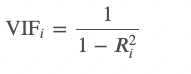

where 𝑅^2 is the coefficient of determination. A feature that has a VIF value that exceeds 5 or 10 may indicate a problematic amount of collinearity.

In [142]:
# using pd.api.types.infer_dtypes() to confirm mixed datatypes
for col in data_min.columns:
  print(col,' - ', pd.api.types.infer_dtype(data_min[col]))

sport  -  integer
dsport  -  integer
dur  -  floating
sbytes  -  integer
dbytes  -  integer
sttl  -  integer
dttl  -  integer
sloss  -  integer
dloss  -  integer
sload  -  floating
dload  -  floating
spkts  -  integer
dpkts  -  integer
swin  -  integer
dwin  -  integer
stcpb  -  integer
dtcpb  -  integer
smeansz  -  integer
dmeansz  -  integer
trans_depth  -  integer
res_bdy_len  -  integer
sjit  -  floating
djit  -  floating
sintpkt  -  floating
dintpkt  -  floating
tcprtt  -  floating
synack  -  floating
ackdat  -  floating
is_sm_ips_ports  -  integer
ct_state_ttl  -  integer
ct_srv_src  -  integer
ct_srv_dst  -  integer
ct_dst_ltm  -  integer
ct_src_ltm  -  integer
ct_src_dport_ltm  -  integer
ct_dst_sport_ltm  -  integer
ct_dst_src_ltm  -  integer
label  -  integer
attack_cat_code  -  integer


In [ ]:
# vif_data = data_min.drop()

In [143]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


VIF = pd.DataFrame()
VIF['feature'] = data_min.columns
VIF['VIF'] = [variance_inflation_factor(data_min.values, i) for i in range(data_min.shape[1])]
# check the result
VIF

,feature,VIF
0,sport,8.708021e-01
1,dsport,1.652898e+00
2,dur,1.026883e+00
3,sbytes,1.196434e+02
4,dbytes,3.420032e+02
5,sttl,9.111624e+00
6,dttl,2.072862e+00
7,sloss,1.774923e+02
8,dloss,1.533979e+03
9,sload,1.707155e+00


In [151]:
VIF['VIF_f'] = VIF['VIF'].apply(lambda x: format(x, 'f'))
VIF.sort_values('VIF')

,feature,VIF,VIF_f
0,sport,8.708021e-01,0.870802
2,dur,1.026883e+00,1.026883
21,sjit,1.269438e+00,1.269438
19,trans_depth,1.444509e+00,1.444509
17,smeansz,1.494020e+00,1.494020
22,djit,1.534198e+00,1.534198
1,dsport,1.652898e+00,1.652898
9,sload,1.707155e+00,1.707155
20,res_bdy_len,1.934165e+00,1.934165
6,dttl,2.072862e+00,2.072862


### Correlation

In [159]:
corr = data_min.corr(method='pearson')


# printing out the features with high correlations (>=0.51)
thresh = 0.51
high_corr = []
for i in range(len(corr.columns)):
  for j in range(i):
    if abs(corr.iloc[i,j]) > thresh:
      col_name = corr.columns[i]
      corr_col_name = corr.columns[j]
      corr_value = corr.iloc[i,j]
      high_corr.append((col_name, corr_col_name, corr_value))

# show the results
high_corr

[('sloss', 'sbytes', 0.9534933518498535),
 ('dloss', 'dbytes', 0.9913420949181156),
 ('dload', 'dsport', 0.5104106558545095),
 ('spkts', 'sbytes', 0.6028424558765995),
 ('spkts', 'dbytes', 0.7270737106771513),
 ('spkts', 'sloss', 0.7255108148223737),
 ('spkts', 'dloss', 0.7664659723932382),
 ('dpkts', 'dbytes', 0.9708090109620348),
 ('dpkts', 'dloss', 0.9921626742606524),
 ('dpkts', 'spkts', 0.8225776198339877),
 ('dwin', 'swin', 0.9972069915267493),
 ('stcpb', 'swin', 0.7417290830172883),
 ('stcpb', 'dwin', 0.7431217550230933),
 ('dtcpb', 'swin', 0.7417315413714746),
 ('dtcpb', 'dwin', 0.743464066452724),
 ('dtcpb', 'stcpb', 0.648669868761931),
 ('dmeansz', 'dbytes', 0.5933529891153169),
 ('dmeansz', 'dloss', 0.6039470715974226),
 ('dmeansz', 'dload', 0.569168304652356),
 ('dmeansz', 'spkts', 0.5218078607341107),
 ('dmeansz', 'dpkts', 0.6033817599812672),
 ('dmeansz', 'swin', 0.5801284235938249),
 ('dmeansz', 'dwin', 0.5820646741082603),
 ('res_bdy_len', 'dbytes', 0.5606288459461233),

In [160]:
corr_df = pd.DataFrame(high_corr)
corr_df.head()

,0,1,2
0,sloss,sbytes,0.953493
1,dloss,dbytes,0.991342
2,dload,dsport,0.510411
3,spkts,sbytes,0.602842
4,spkts,dbytes,0.727074


In [162]:
corr_df.to_csv('high_corr.csv', index = False)

### Random Forest for feature importance

In [155]:
X = data_min.drop(['label', 'attack_cat_code'], axis=1)
y = data_min['attack_cat_code']

In [156]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

#### Display features in descending order of their importance

 1) ct_state_ttl                   0.196493
 2) sttl                           0.167359
 3) sbytes                         0.132228
 4) smeansz                        0.066144
 5) sload                          0.049241
 6) dmeansz                        0.038197
 7) dbytes                         0.035019
 8) dsport                         0.031849
 9) dpkts                          0.028320
10) ct_srv_src                     0.021640
11) dintpkt                        0.019169
12) ct_srv_dst                     0.018238
13) sport                          0.018177
14) ct_dst_sport_ltm               0.016559
15) tcprtt                         0.016484
16) dur                            0.015295
17) dload                          0.015232
18) dttl                           0.014867
19) ct_src_dport_ltm               0.012752
20) ct_dst_src_ltm                 0.012474
21) synack                         0.009293
22) ackdat                         0.008887
23) ct_dst_ltm                  

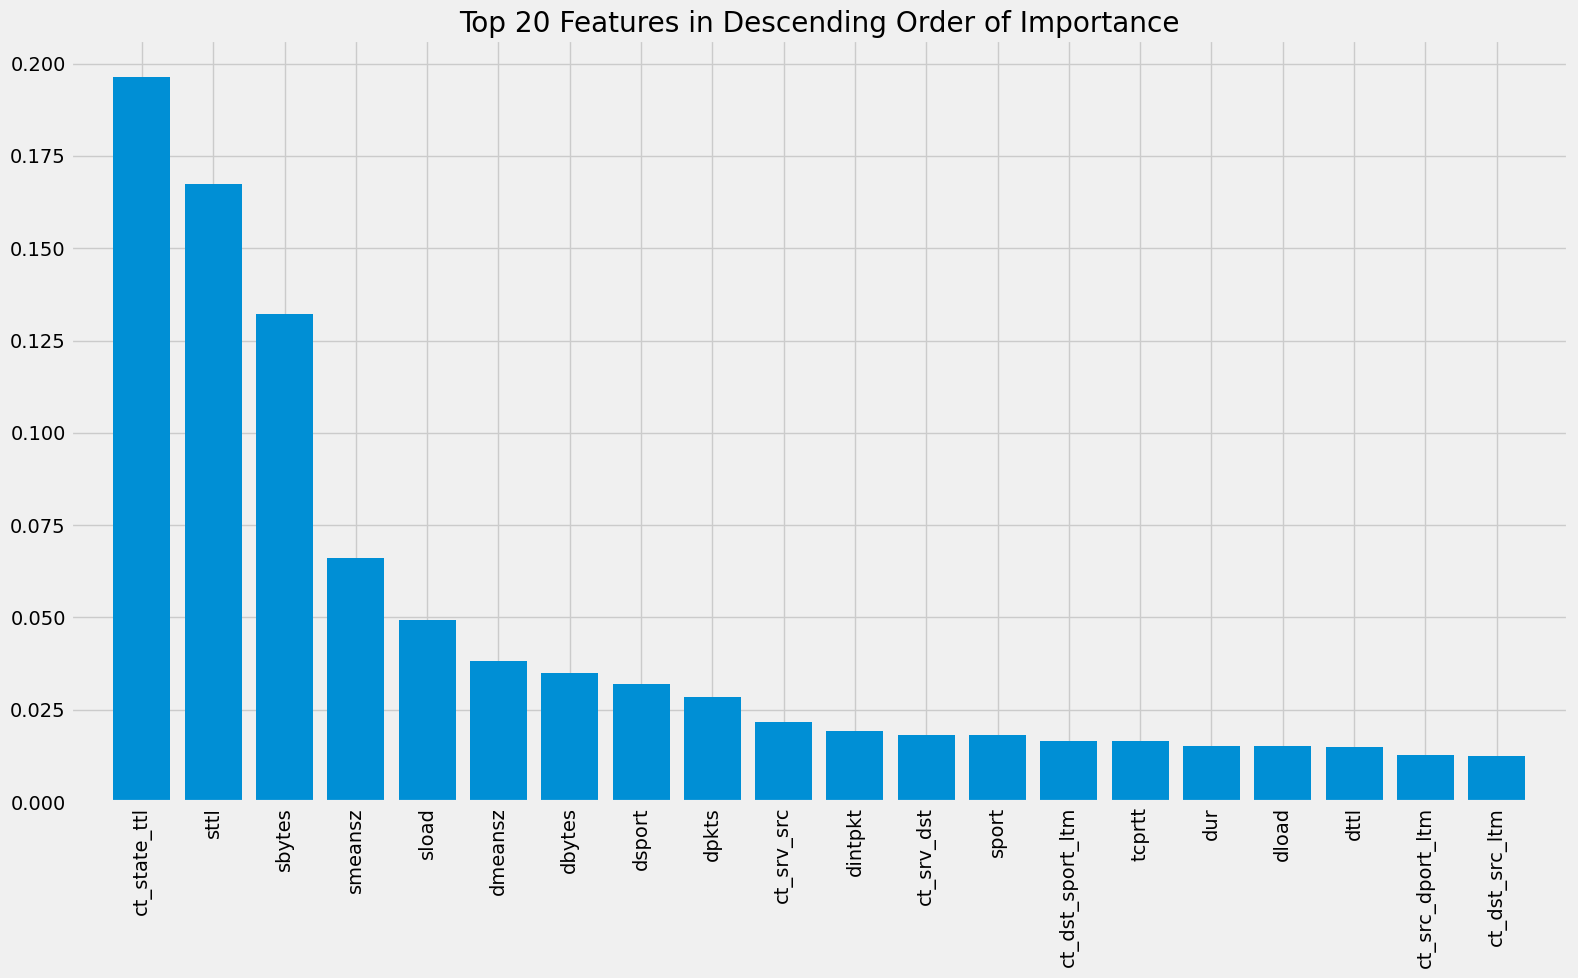

In [157]:
# Reset style 
# plt.style.use('seaborn')
plt.style.use('fivethirtyeight')

feat_labels = X.columns

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
    
fig, ax = plt.subplots(figsize=(16, 10))
plt.title('Top 20 Features in Descending Order of Importance')
plt.bar(range(20),#X_train.shape[1]), 
        importances[indices][:20],
        align='center')

plt.xticks(range(20),#X_train.shape[1]), 
           feat_labels[indices][:20], 
           rotation=90,
          fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([-1, 20])#X_train.shape[1]])
plt.tight_layout()
plt.show()

#### Identify top 95% of features

In [163]:
# List of features for later use
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# list of x locations for plotting
x_values = list(range(len(importances)))

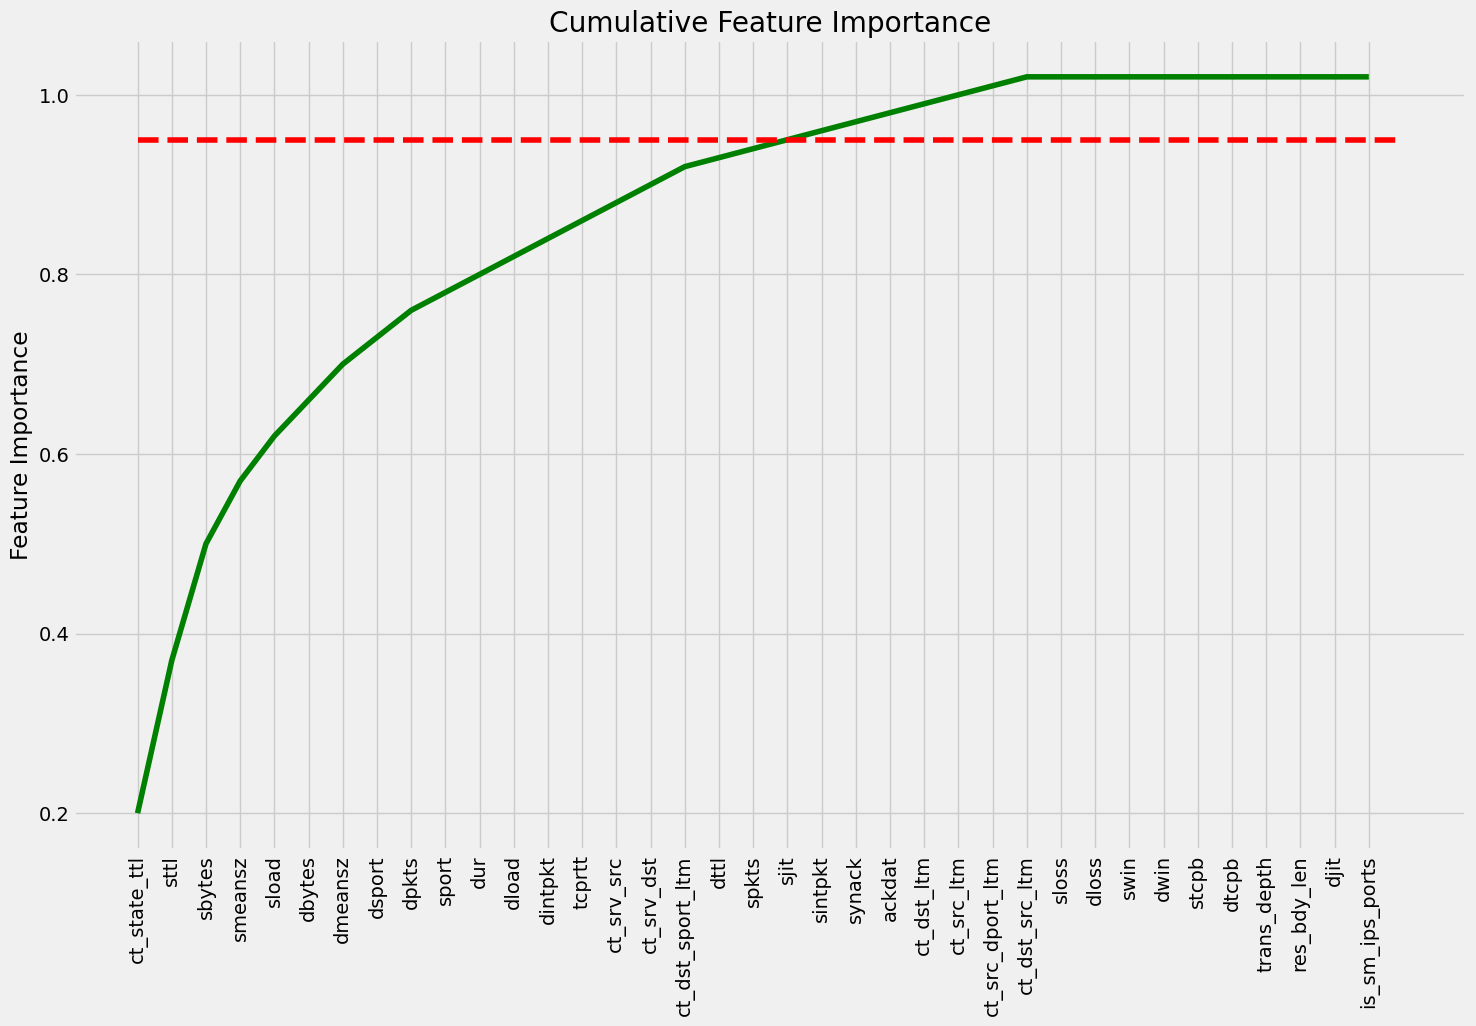

In [164]:
# Reset style 
plt.style.use('fivethirtyeight')
# plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(16, 10))
# Make a line graph
plt.plot(x_values, 
         cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical', fontsize = 14)
plt.yticks(fontsize = 14)

# Axis labels and title
# plt.xlabel('Feature Name'); 
plt.ylabel('Feature Importance'); plt.title('Cumulative Feature Importance');

### Removing columns that:
1. Of low(er) eimportance according to RF Feature importance
2. Have high VIF values
3. Correlated to one or more other columns

You could find details in the spreadsheet:<br>
https://docs.google.com/spreadsheets/d/1QZ2ZKKGMc-wNAIIQ8s-u_469jtdJXa848hEpJbxmUhc/edit#gid=1126102638

In [169]:
# taking into account feature importance, getting the names of 
# highly correlated (and less important) features to drop from t

# cross-referencing with feature importance and VIF see details in the google sheet
# https://docs.google.com/spreadsheets/d/1QZ2ZKKGMc-wNAIIQ8s-u_469jtdJXa848hEpJbxmUhc/edit#gid=1126102638

cols_keep = ['sttl',
            'sbytes',
            'smeansz',
            'sload',
            'dmeansz',
            'dbytes',
            'dsport',
            'ct_srv_src',
            'dintpkt',
            'sport',
            'ct_dst_sport_ltm',
            'tcprtt',
            'dur',
            'dttl',
            'sintpkt',
            'ct_src_ltm',
            'spkts',
            'sjit',
            'djit',
            'stcpb',
            'res_bdy_len',
            'trans_depth',
            'label', 
            'attack_cat_code']

data_top = data_min[[col for col in data_min.columns if col in cols_keep]]
data_top.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,label,attack_cat_code
0,33661,1024,0.036133,528,304,31,29,87676.085938,4,0,...,9.89101,10.682733,7.005,7.564333,0.0,2,3,1,0,0
1,1464,53,0.001119,146,178,31,29,521894.531250,2,0,...,0.00000,0.000000,0.017,0.013000,0.0,12,2,1,0,0
2,3593,53,0.001209,132,164,31,29,436724.562500,2,0,...,0.00000,0.000000,0.043,0.014000,0.0,6,1,1,0,0
3,49664,53,0.001169,146,178,31,29,499572.250000,2,0,...,0.00000,0.000000,0.005,0.003000,0.0,7,1,1,0,0
4,32119,111,0.078339,568,312,31,29,43503.234375,4,0,...,29.68222,34.370338,21.003,24.315001,0.0,2,3,1,0,0


In [170]:
data_top.columns

Index(['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload',
       'spkts', 'stcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'ct_srv_src',
       'ct_src_ltm', 'ct_dst_sport_ltm', 'label', 'attack_cat_code'],
      dtype='object')

In [177]:
print(features.loc[features['Name'] == 'sport'].to_string(index = False, header=False))

2 sport integer Source port number


In [179]:
pd.options.display.max_colwidth = 100

for col in data_top.columns:
  print(features.loc[features['Name'] == col].to_string(index = False, header=False))

2 sport integer Source port number
4 dsport integer Destination port number
7 dur Float Record total duration
8 sbytes Integer Source to destination transaction bytes 
9 dbytes Integer Destination to source transaction bytes
10 sttl Integer Source to destination time to live value 
11 dttl Integer Destination to source time to live value
15 sload Float Source bits per second
17 spkts integer Source to destination packet count 
21 stcpb integer Source TCP base sequence number
23 smeansz integer Mean of the ?ow packet size transmitted by the src 
24 dmeansz integer Mean of the ?ow packet size transmitted by the dst 
25 trans_depth integer Represents the pipelined depth into the connection of http request/response transaction
26 res_bdy_len integer Actual uncompressed content size of the data transferred from the server’s http service.
27 sjit Float Source jitter (mSec)
28 djit Float Destination jitter (mSec)
31 sintpkt Float Source interpacket arrival time (mSec)
32 dintpkt Float Destina

### One Hot Encoding Categorical Variables
* sport - nominal
* dsport - nominal
* attack_cat_code - nominal (target for multi-class)
* label - binary (target)



In [252]:
# removing labels from X 
features = data_top.drop(['label', 'attack_cat_code'], axis=1)
features.shape

(2539735, 22)

In [184]:
# creating a dataframe for target variables
targets = data_top[['label', 'attack_cat_code']]

In [185]:
# creating target variables for binary and multiclass classification
y = targets['label']
y_m = targets['attack_cat_code']

In [186]:
# one-hot encoding the data in X IS NOT NECESSARY since even though the values are nominal, they are represented by numbers
# data_oh = pd.get_dummies(features, drop_first = True)
# data_oh.shape

(2539735, 22)

## Train / Test Split
Setting aside 10% of the original data for testing and exporiting both


In [192]:
# splitting into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(
    features, y_m, test_size=0.15, random_state=42, stratify=y_m)

In [193]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2158774, 22), (2158774,), (380961, 22), (380961,))

In [194]:
# checking the number of classes in y_test
y_test.value_counts()

0    332768
1     32322
2      6679
3      3637
4      2453
5      2098
6       402
7       349
8       227
9        26
Name: attack_cat_code, dtype: int64

### Exporting the data after the cleaning is done

In [ ]:
# merging binary classification data into one dataframe
train = pd.concat([X_train, y_train], axis = 1)
# checking the result
train.shape

In [196]:
# exporting the results to csv
train.to_csv('train_imbalanced_85.csv', index = False)

In [198]:
# downloading from colab
from google.colab import files
files.download('train_imbalanced_85.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [197]:
# merging binary classification data into one dataframe
test = pd.concat([X_test, y_test], axis = 1)
# checking the result
test.shape

(380961, 23)

In [199]:
# exporting the results to csv
test.to_csv('test_imbalanced_15.csv', index = False)
# downloading from colab
files.download('test_imbalanced_15.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualizing the classes

In [200]:
# get the labels
codes = {'Normal':0,
         'Generic':1,
         'Exploits':2,
         'Fuzzers': 3,
         'DoS':4,
         'Reconnaissance':5,
         'Analysis':6,
         'Backdoor':7,
         'Shellcode':8,
         'Worms':9   
}
labels = [x for x in codes.keys()]
# labels

# reversing the codes
reverse_codes  = dict((v,k) for k,v in codes.items())

train['attack_cat'] = train['attack_cat_code'].map(reverse_codes)
# data['attack_cat'].value_counts()

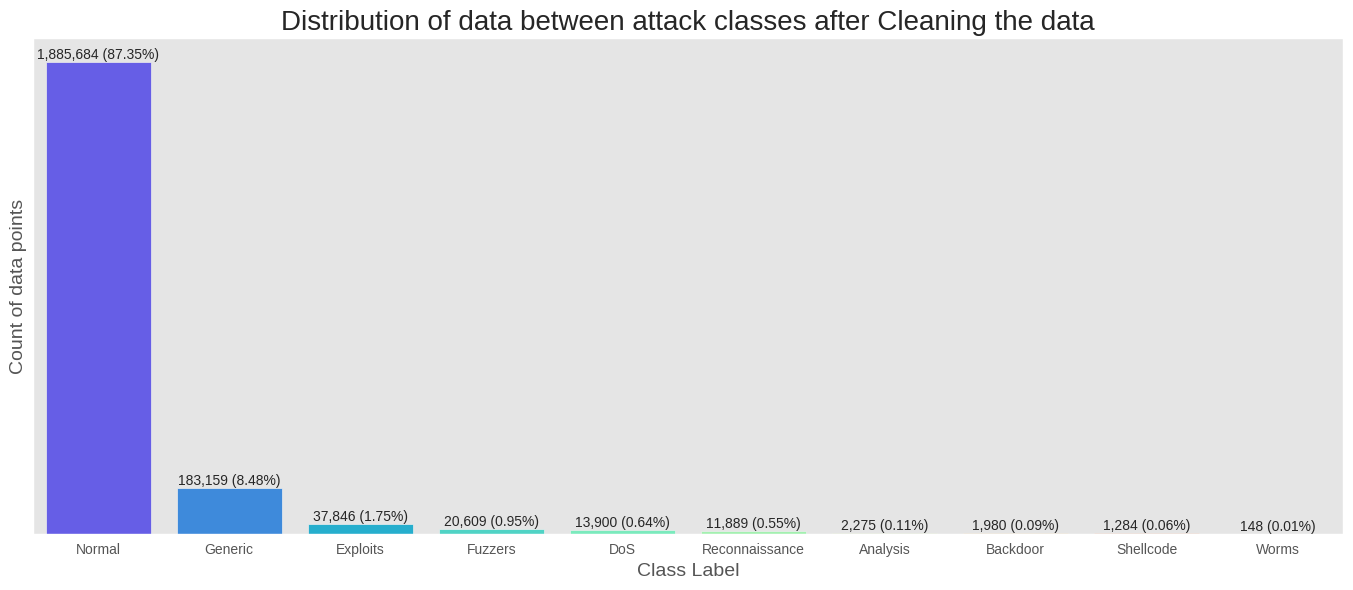

In [205]:
# fig = plt.figure(figsize=(14,5))
# sns.set_style("whitegrid")
# plt.style.use('seaborn')
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,6))

ax = sns.countplot(
    data=train,
    x = "attack_cat",
    palette='rainbow',
    order = train["attack_cat"].value_counts().index)


        
abs_values = train["attack_cat"].value_counts(ascending=False)
rel_values = train["attack_cat"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]:,} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)#, fontsize = 14)

ax.set_xlabel('Class Label', fontsize = 14)
ax.set_ylabel('Count of data points', fontsize = 14)
ax.set_title('Distribution of data between attack classes after Cleaning the data', fontsize = 20)
plt.tight_layout()
# plt.ylim((0,250000))
plt.yticks([]) 
plt.show()



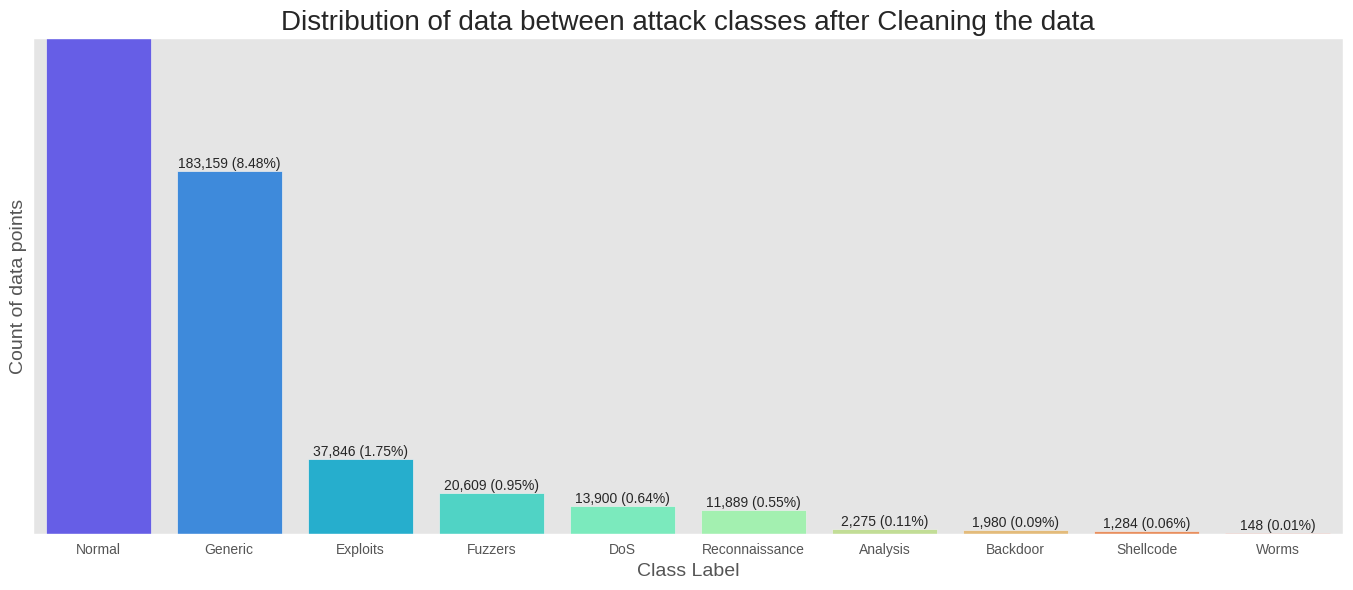

In [206]:
# fig = plt.figure(figsize=(14,5))
# sns.set_style("whitegrid")
# plt.style.use('seaborn')
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,6))

ax = sns.countplot(
    data=train,
    x = "attack_cat",
    palette='rainbow',
    order = train["attack_cat"].value_counts().index)


        
abs_values = train["attack_cat"].value_counts(ascending=False)
rel_values = train["attack_cat"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]:,} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)#, fontsize = 14)

ax.set_xlabel('Class Label', fontsize = 14)
ax.set_ylabel('Count of data points', fontsize = 14)
ax.set_title('Distribution of data between attack classes after Cleaning the data', fontsize = 20)
plt.tight_layout()
plt.ylim((0,250000))
plt.yticks([]) 
plt.show()



In [211]:
train = train.drop('attack_cat', axis = 1)
train.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,attack_cat_code
646493,1043,53,0.000005,264,0,60,0,2.112000e+08,2,0,...,0,0.000000,0.000000,0.005000,0.000000,0.000000,23,23,23,0
238748,47439,53,0.000006,114,0,254,0,7.600000e+07,2,0,...,0,0.000000,0.000000,0.006000,0.000000,0.000000,51,40,18,1
667993,54472,53,0.001060,146,178,31,29,5.509434e+05,2,0,...,0,0.000000,0.000000,0.010000,0.006000,0.000000,4,5,1,0
11487,1043,53,0.000007,114,0,254,0,6.514286e+07,2,0,...,0,0.000000,0.000000,0.007000,0.000000,0.000000,25,25,25,1
264082,62795,5190,0.006134,1920,4312,31,29,2.390610e+06,22,3198205079,...,0,17.042793,13.784042,0.275381,0.238696,0.000808,5,3,1,0


In [245]:
for col in train.columns:
  c_name = col
  f_range = train[col].max() - train[col].min()
  mean_ = train[col].mean()
  std_ = train[col].std()
  # dtype_ = train[col].dtype
  print(f'{c_name:<18} range: {f_range:<20} mean: {mean_:<22} std: {std_:<20} mean/std: {std_/mean_:.2f}')

sport              range: 65535                mean: 30530.44762814449      std: 20441.45801137486    mean/std: 0.67
dsport             range: 65535                mean: 11225.879235158474     std: 18427.736266711414   mean/std: 1.64
dur                range: 8786.6376953125      mean: 0.6549458503723145     std: 12.43690299987793    mean/std: 18.99
sbytes             range: 13677393             mean: 4320.5553999631275     std: 54964.407897604106   mean/std: 12.72
dbytes             range: 14655417             mean: 36479.25526572027      std: 161161.44282950024   mean/std: 4.42
sttl               range: 255                  mean: 62.790761793499456     std: 74.63929615720242    mean/std: 1.19
dttl               range: 254                  mean: 30.77823014359076      std: 42.86910052117805    mean/std: 1.39
sload              range: 5988000256.0         mean: 36933676.0             std: 118325104.0          mean/std: 3.20
spkts              range: 10200                mean: 33.285420


columns with ration of mean to std above 2:

* dur
* sbytes - nominal
* dbytes - nominal
* sload
* spkts
* trans_depth
* res_bdy_len
* sjit
* djit
* sintpkt
* dintpkt
* tcprtt


In [253]:
train.columns

Index(['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload',
       'spkts', 'stcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'ct_srv_src',
       'ct_src_ltm', 'ct_dst_sport_ltm', 'attack_cat_code'],
      dtype='object')

In [254]:
train[['dur', 
       'sload',
       'spkts',
       'trans_depth',
       'res_bdy_len',
       'sjit',
       'djit',
       'sintpkt',
       'dintpkt',
       'tcprtt']].describe()

# Confirming that all of these columns have standard deviations that are significantly higher than the means so they could be candidates for log transformation

,dur,sload,spkts,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt
count,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06,2.158774e+06
mean,6.549459e-01,3.693368e+07,3.328542e+01,8.338390e-02,4.243795e+03,1.593707e+03,7.307517e+02,1.939365e+02,7.935072e+01,6.180024e-03
std,1.243690e+01,1.183251e+08,7.574174e+01,3.314992e-01,4.746279e+04,1.693448e+04,3.273253e+03,2.787614e+03,1.442189e+03,4.612645e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.037000e-03,1.345404e+05,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-03,6.000000e-03,0.000000e+00
50%,1.587100e-02,5.893038e+05,1.200000e+01,0.000000e+00,0.000000e+00,1.916203e+01,2.669062e+00,4.684970e-01,4.149020e-01,6.130000e-04
75%,2.161923e-01,2.038082e+06,4.400000e+01,0.000000e+00,0.000000e+00,4.161455e+02,6.365033e+01,7.401348e+00,6.224000e+00,7.020000e-04
max,8.786638e+03,5.988000e+09,1.020000e+04,1.720000e+02,6.558056e+06,1.483831e+06,7.812211e+05,8.437149e+04,5.948532e+04,1.003751e+01
